# Solving Linear Systems (HHL and Improvements)
### Chris Hsu, Alex Kim, Quinn Powell
This notebook contains all the code used in our final project.

In [ ]:
%pip install qiskit[visualization]
%pip install qiskit_ibm_runtime
%pip install qiskit_aer

In [2]:
# Imports for Qiskit
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

import numpy as np

### HHL Algorithm

Most of the code for the HHL algorithm was adapted from [this paper](https://doi.org/10.1109/ACCESS.2023.3297658), which provides their code [here](https://github.com/hywong2/HHL_Example). Since the paper is a few years old, some of the code needed to be updated to work with the most recent versions of Qiskit.

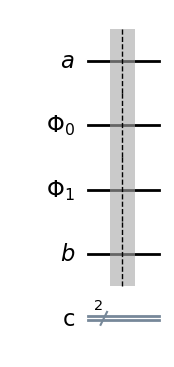

In [6]:
clock = QuantumRegister(2, name='\Phi')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='a')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)

circuit.barrier()
circuit.draw(output='mpl')

In [7]:
def qft_dagger(circ, q, n):      
    circ.h(clock[1])
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(-np.pi/float(2**(k-j)), q[k], q[j])
    circ.h(clock[0])
    circ.swap(clock[0], clock[1])

def qft(circ, q, n):
    circ.swap(clock[0], clock[1])
    circ.h(clock[0])
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(np.pi/float(2**(k-j)), q[k], q[j])
    circ.h(clock[1])

In [8]:
def qpe(circ, clock, target):
    circuit.barrier()

    # e^{i*A*t}
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U')
    
    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2')

    circuit.barrier()
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2')

    #circuit.barrier();

    # e^{i*A*t}
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U')

    circuit.barrier()

In [9]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement C = 1
    circuit.cry(np.pi, clock[0], ancilla)
    circuit.cry(np.pi/3, clock[1], ancilla)

    circuit.barrier()
    
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

### Creating the Circuit

We can now create the actual circuit we will test.

In [10]:
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()
circuit.h(clock)
hhl(circuit, ancilla, clock, input, measurement)
circuit.h(clock)
circuit.barrier()

circuit.measure(input, measurement[1])

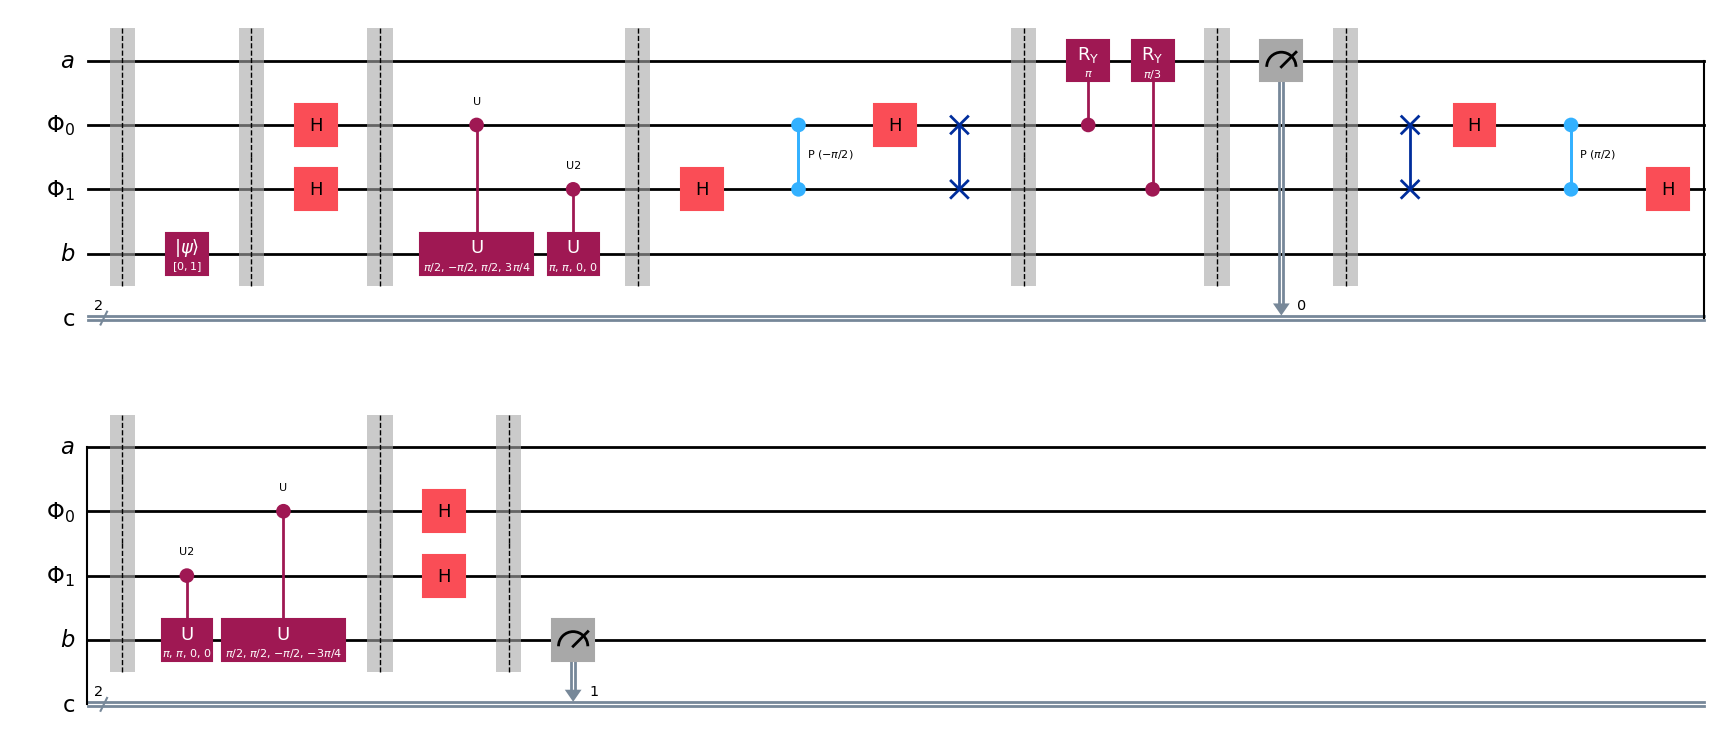

In [11]:
circuit.draw('mpl',scale=1)

### Running the Circuit

To run the circuit, we will use two different simulators in addition to the quantum computer at RPI.

In [12]:
service = QiskitRuntimeService()

real_backend = service.backend('ibm_rensselaer')
aer_simulator = AerSimulator.from_backend(real_backend)
test_backend = AerSimulator(method='statevector')

First, we run the circuit on a statevector simulator, which should provide outputs similar to the theoretical. We can use this to verify that our circuit is correct, since if the result is incorrect, we know there is a problem with our circuit.

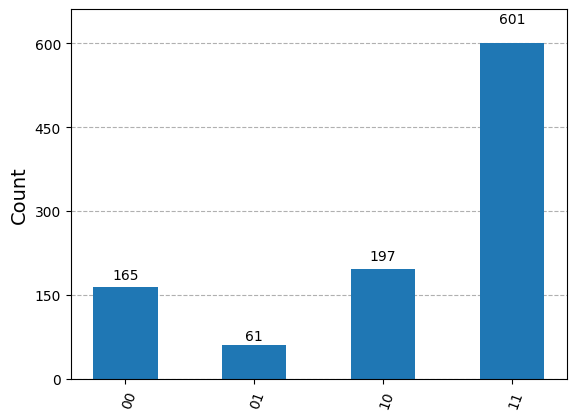

In [13]:
result = test_backend.run(circuit, shots=1024).result()
counts = result.get_counts(circuit)
plot_histogram(counts)

To be able to run on the IBM Quantum System One or the simulator based off it, we first need to transpile the circuit.

In [14]:
transp_circuit = transpile(circuit, real_backend)

We then run the transpiled circuit on a simulator of the ```ibm_rensselaer``` quantum computer.

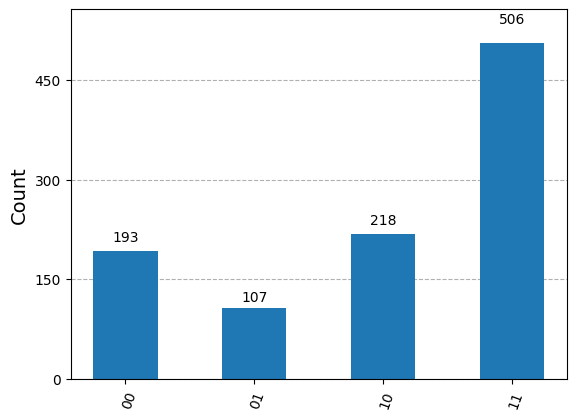

In [18]:
result = aer_simulator.run(transp_circuit, shots=1024).result()
counts = result.get_counts(transp_circuit)
plot_histogram(counts)

The next block runs the transpiled circuit on the actual quantum hardware.

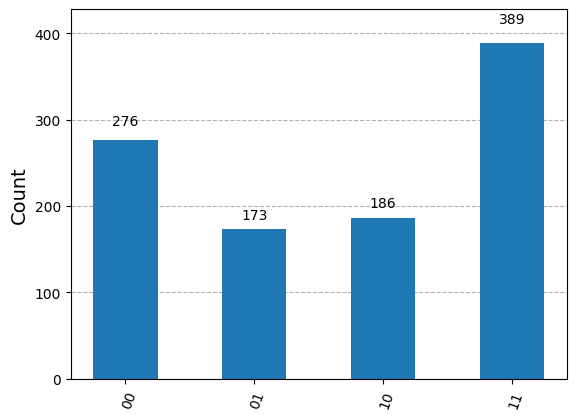

In [34]:
sampler = Sampler(mode=real_backend)
result = sampler.run([transp_circuit], shots=1024).result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)